In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from pprint import pprint
import numpy as np
import torchinfo
from matplotlib import pyplot as plt

In [2]:
import time
import cv2
from PIL import Image

In [3]:
# Displaying routine

def display_images(in_, out, n=1, label='', count=False, energy=None):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 64, 64)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 64, 64)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            c = 4 * N + i
            if count: plt.title(str(c), color='w')
            if count and energy is not None: plt.title(f'{c}, e={energy[c].item():.2f}', color='w')


In [4]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [5]:
### Define data loading step

# batch_size = 64
# path_data = r'C:/Users/utkar/Desktop/ML/Dataset'
# kwargs = {'num_workers': 1, 'pin_memory': True}
# train_loader = torch.utils.data.DataLoader(
#     MNIST(path_data, train=True, download=False,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     MNIST(path_data, train=False, transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)
channels_img = 3
batch_size = 64
data_dir = r'C:/Users/utkar/Desktop/ML/Dataset/anime_faces/img/'
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
    ])
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train, test = train_test_split(dataset, test_size=0.2, train_size=0.8)

In [6]:

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True
)

test_loader = DataLoader(
    test,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False
)

In [7]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def bn(in_c, out_c):
    bn = nn.Sequential(
        nn.Conv2d(in_c, in_c*2, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(in_c*2, in_c*2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_c*2, out_c, kernel_size=1),
        nn.ReLU()
    )
    return bn

In [9]:
#class MappingNetwork(nn.Module):
#    def __init__

In [205]:
# Defining the model

class VAE(nn.Module):
    def __init__(self, imgChannels=3, feature_dim=128*8*8, z_dim=384):
        super(VAE, self).__init__()
        # encoder
        self.encConv1 = nn.Conv2d(imgChannels, 32*2, kernel_size=4, stride=2, padding=1)
        self.bn_1 = bn(32*2, 32)
        self.encConv2 = nn.Conv2d(32*3, 64*2, kernel_size=4, stride=2, padding=1)
        self.bn_2 = bn(64*2, 64)
        self.encConv3 = nn.Conv2d(64*3, 128, kernel_size=4, stride=2, padding=1)
        self.encFC1 = nn.Linear(feature_dim, z_dim)
        self.encFC2 = nn.Linear(feature_dim, z_dim)

        # decoder
        self.decFC = nn.Linear(z_dim, feature_dim)
        self.decTconv1 = nn.ConvTranspose2d(128, 64*2, kernel_size=4, stride=2, padding=1)
        self.bn_3 = bn(64*2, 64)
        self.decTconv2 = nn.ConvTranspose2d(64*3, 32*2, kernel_size=4, stride=2, padding=1)
        self.bn_4 = bn(32*2, 32)
        self.decTconv3 = nn.ConvTranspose2d(32*3, imgChannels, kernel_size=4, stride=2, padding=1)
        
    def encoder(self, x):
        x = F.relu(self.encConv1(x))
        y = self.bn_1(x)
        #print(x.shape, y.shape)
        x = F.relu(self.encConv2(torch.concat([y, x], axis=1)))
        y = self.bn_2(x)
        x = F.relu(self.encConv3(torch.concat([y, x], axis=1)))
        x = x.view(-1, 8192)
        mu = self.encFC1(x)
        logvar = self.encFC2(x)
        return mu, logvar
        
    def reparameterise(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.rand_like(std)
            return mu + std*eps
        else:
            return mu
        #if self.training:
        #    std = logvar.mul(0.5).exp_()
        #    eps = std.data.new(std.size()).normal_()
        #    return eps.mul(std).add_(mu)
        #else:
        #    return mu
        
    def decoder(self, x):
        x = F.relu(self.decFC(x))
        x = x.view(-1, 128, 8, 8) + F.relu(torch.randn(x.shape[0], 128, 8, 8)*0.2).to(device)
        x = F.relu(self.decTconv1(x)) + F.relu(torch.randn(x.shape[0], 128, 16, 16)*0.2).to(device)
        y = self.bn_3(x)
        x = F.relu(self.decTconv2(torch.concat([y, x], axis=1))) + F.relu(torch.randn(x.shape[0], 64, 32, 32)*0.01).to(device)
        y = self.bn_4(x)
        x = torch.sigmoid(self.decTconv3(torch.concat([y, x], axis=1)))
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterise(mu, logvar)
        out = self.decoder(z)
        return out, mu, logvar

model = VAE().to(device)
pprint(torchinfo.summary(model, (1, 3, 64, 64)))

y = torch.rand((1, 3, 64, 64)).to('cuda')
x = model(y)
print(np.shape(x[0].cpu()))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           3,136
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          8,320
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-3                       [1, 128, 32, 32]          147,584
│    └─ReLU: 2-4                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 32, 32, 32]           4,128
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 128, 16, 16]          196,736
├─Sequential: 1-4                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 256, 16, 16]          33,024
│    └─ReLU: 2-8                         [1, 256, 16, 16]     

In [206]:
# Setting the optimiser

learning_rate = 3e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [207]:
PATH = r'C:/Users/utkar/Desktop/ML/pytorch/autoencoder/autoencoder_using_mseloss.pth.tar'
model = VAE().to(device)
#optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#model.eval()
# - or -
model.train()

VAE(
  (encConv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (encConv2): Conv2d(96, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (encConv3): Conv2d(192, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (encFC1): Linear(in_features=8192, out_features=384, bias=True)
  (encFC2): Linear(in_features=8192, out_features=384, bias=True)
  (decFC): Linear(in_features=384, out_features=8192, bias=True)
  (decTconv1)

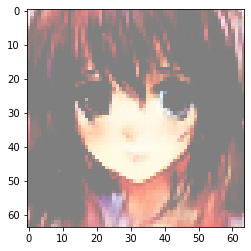

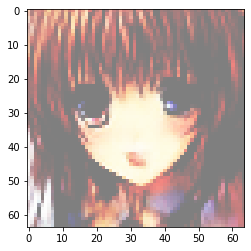

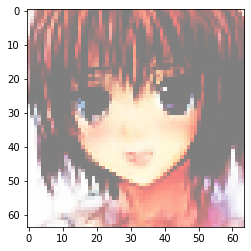

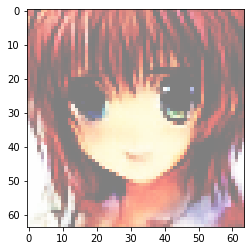

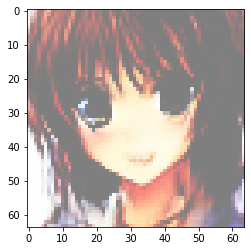

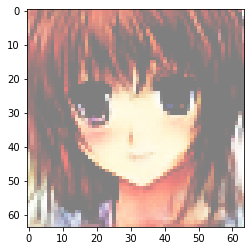

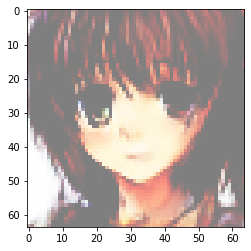

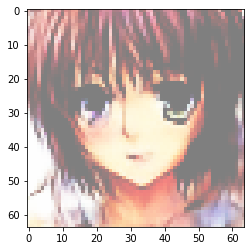

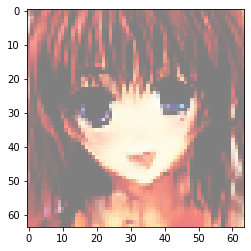

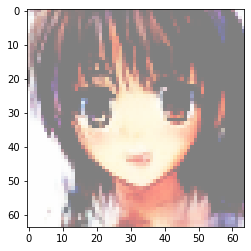

In [208]:
# Generating a few samples
for i in range(10):
    #N = 16
    #z = torch.randn((N, 384)).to(device)
    ##print(z)
    #sample = model.decoder(z)
    #plt.imshow(sample[0].detach().cpu().permute(1, 2, 0))
    #plt.show()
    
    std = torch.exp(logVar/2)
    eps = torch.tensor(np.random.randn(40, 384), dtype=torch.float32).to(device)  #torch.rand_like(std)
    #z = mu*np.random.randint(1, 1000)/1000 + std*eps*np.random.randint(1, 1000)/1000 + torch.rand_like(mu)*1.5
    z = torch.rand_like(mu)*2.25  #+(mu + std*eps) 
    sample = model.decoder(z)
    img = np.array((sample[0].detach().cpu().permute(1, 2, 0)+1)/2)
    plt.imshow(img)
    plt.show()
#display_images(None, sample, N // 4, count=True)

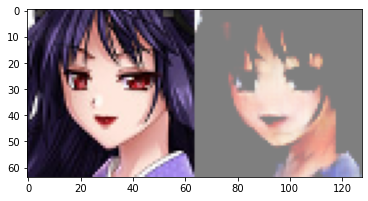

====> Test set loss: 877.2618
Epoch 1: Loss 16323.1953125


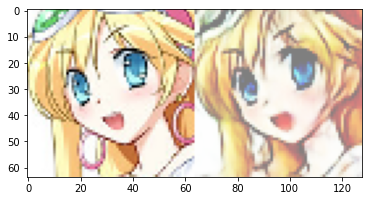

====> Test set loss: 877.1334
Epoch 2: Loss 19108.685546875


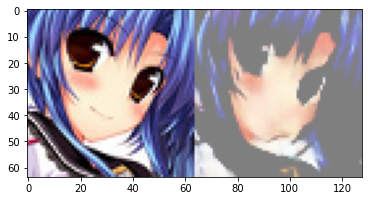

====> Test set loss: 876.9021
Epoch 3: Loss 18768.82421875


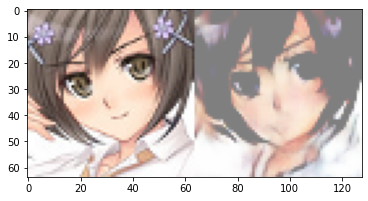

====> Test set loss: 877.1025
Epoch 4: Loss 12967.8935546875


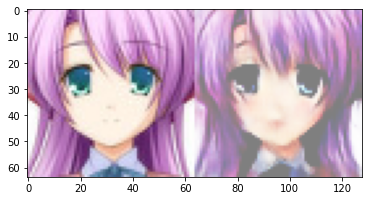

====> Test set loss: 875.8859
Epoch 5: Loss 18653.421875


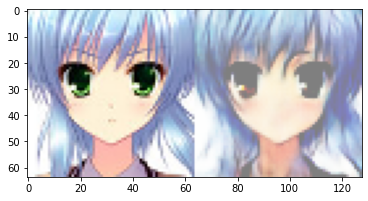

====> Test set loss: 876.5682
Epoch 6: Loss 15828.4140625


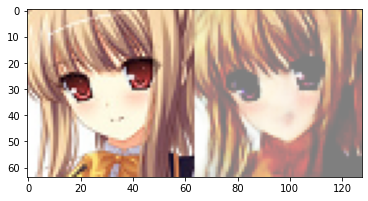

====> Test set loss: 877.3316
Epoch 7: Loss 16291.8544921875


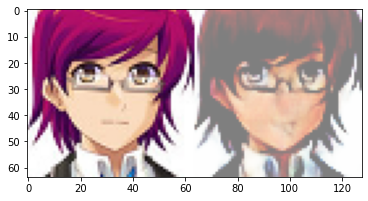

====> Test set loss: 876.5541
Epoch 8: Loss 20745.76171875


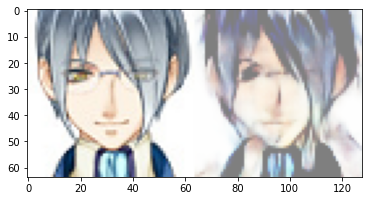

====> Test set loss: 876.4934
Epoch 9: Loss 16621.587890625


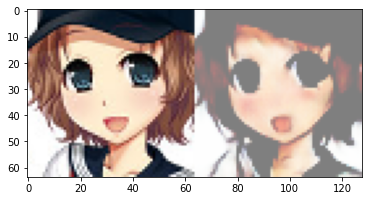

====> Test set loss: 876.2375
Epoch 10: Loss 18584.4296875


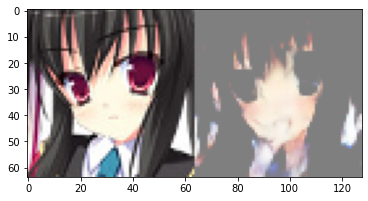

====> Test set loss: 877.0080
Epoch 11: Loss 19354.0859375


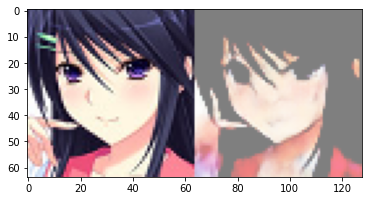

====> Test set loss: 876.6153
Epoch 12: Loss 17679.263671875


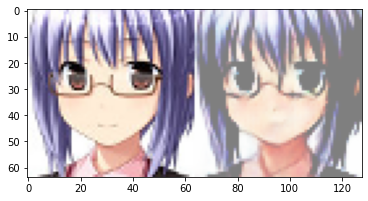

====> Test set loss: 875.4747
Epoch 13: Loss 15035.91796875


In [150]:
epochs = 13

codes = dict(μ=list(), logσ2=list(), x=list())
for epoch in range(epochs):
    epoch += 1
    if epoch%50 == 0:
        time.sleep(10)
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = model(imgs)
        #print(out.shape, imgs.shape)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.mse_loss(out, imgs, reduction='sum')/3 + 2*kl_divergence/3

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        means, logvars, labels = list(), list(), list()
        model.eval()
        img = (imgs.cpu()[2].permute(1, 2, 0)+1)/2
        gen = (out.cpu()[2].permute(1, 2, 0)+1)/2
        img = np.concatenate((img, gen), axis=1)
        plt.imshow(img)
        plt.show()
        test_loss = 0
        for imgs, x in test_loader:
            imgs = imgs.to(device)
            # ===================forward=====================
            
            out, mu, logVar = model(imgs)
            #print(out.shape, imgs.shape)
            kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
            test_loss += (F.mse_loss(out, imgs, reduction='sum')/3 + 2*kl_divergence/3).item()

            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logVar.detach())
            labels.append(x.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['x'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    model.train()
    print('Epoch {}: Loss {}'.format(epoch, loss))

In [ ]:
# 300+200+150+50+50+50+200+500
#------------------------------

In [151]:
PATH = r'C:/Users/utkar/Desktop/ML/pytorch/autoencoder/autoencoder_using_mseloss.pth.tar'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, PATH)

In [74]:
np.shape(std.cpu())

torch.Size([40, 384])

In [ ]:
# Display last test batch
with torch.no_grad():
    ỹ = model(y)[0].view(-1, 28, 28)
energy = y.squeeze().sub(ỹ).pow(2).sum(dim=(1,2))
display_images(None, y, 4, count=True, energy=energy)

In [ ]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 0, 6
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1],
    sample.data[0],
    sample.data[1],
    y[A].data.view(-1) - sample.data[0],
    y[B].data.view(-1) - sample.data[1]
)), 0), 2)

In [ ]:
# Perform an interpolation between input A and B, in N steps

N = 16
# code = torch.Tensor(N, 20).to(device)
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    # code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
# samples = model.decoder(code)
display_images(None, samples, N // 4, count=True)

In [ ]:
ẏ = sample[9]
with torch.no_grad():
    ỹ = model(ẏ)[0]
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((ẏ).view(28, 28))
plt.subplot(122), plt.imshow((ỹ).view(28, 28))

In [ ]:
N = 16
samples = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    samples[i] = i / (N - 1) * y[B].data + (1 - i / (N - 1) ) * y[A].data
with torch.no_grad():
    reconstructions = model(samples)[0].view(-1, 28, 28)

plt.title(f'{A = }, {B = }')
plt.plot(samples.sub(reconstructions).pow(2).sum(dim=(1,2)), '-o')

In [104]:
from sklearn.manifold import TSNE

In [106]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 4000  # samples per epoch
epochs = (0, 24, 49)
for epoch in epochs:
    Y.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(Y[-1].detach().cpu()))
    X.append(codes['x'][epoch][:N])

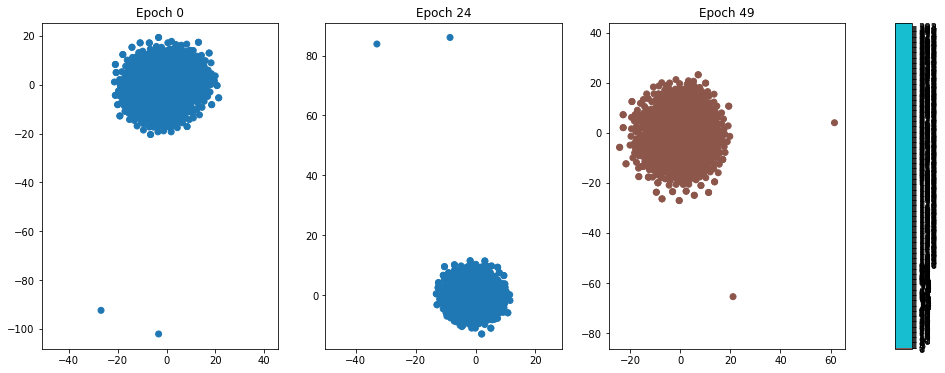

In [107]:
f, a = plt.subplots(ncols=3, figsize=(18, 6))
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=X[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(384), boundaries=np.arange(389) - .5)